# **CODE - COMPUTER VISION PROJECT**

---



# Setup

## Installation des librairies

In [1]:
# Détection d'objets
!pip install ultralytics  # YOLO v8
!pip install torch torchvision

# OCR
!pip install easyocr pytesseract

# Vision-Language
!pip install transformers pillow

# Utilitaires
!pip install opencv-python-headless numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 17.6 MB/s eta 0:00:00


In [2]:
!pip install ultralytics opencv-python-headless pillow numpy matplotlib
!pip install gtts playsound  # Pour la synthèse vocale


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.6 MB/s eta 0:00:00
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=4afaf61212fb9424e3c9fc68644ef19ae47191e097b4bfce06fe2a0487491af4
  Stored in directory: /root/.cache/pip/wheels/cf/42/ff/7c587bae55eec67b909ca316b250d9b4daedbf272a3cbeb907
Successfully built playsound
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1


## Imports

In [3]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from pathlib import Path
from collections import Counter

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA disponible: False


# Module 1 : Yolo - Détéction d'objets

## Chargement du modèle

In [5]:
# Chargement du modèle YOLOv8 pré-entraîné sur COCO
# Options: yolov8n (nano - rapide), yolov8s (small), yolov8m (medium), yolov8l (large)
model = YOLO('yolov8n.pt')
print(f"Classes disponibles: {len(model.names)} catégories")

Classes disponibles: 80 catégories


## Détéction des obstacles et zones dangereuses

In [6]:
OBSTACLES_CRITIQUES = {
    'person': 'Personne détectée',
    'car': 'Véhicule',
    'truck': 'Camion',
    'bus': 'Bus',
    'bicycle': 'Vélo',
    'motorcycle': 'Moto',
    'traffic light': 'Feu de circulation',
    'stop sign': 'Stop',
    'bench': 'Banc',
    'chair': 'Chaise',
    'stairs': 'Escaliers',
    'dog': 'Chien',
    'cat': 'Chat'
}

# Zones de danger (distance basée sur la taille de la bbox)
def evaluer_distance(bbox_area, image_area):
    """
    Estime la proximité basée sur la taille de la boîte englobante
    """
    ratio = bbox_area / image_area
    if ratio > 0.3:
        return "TRÈS PROCHE - ATTENTION"
    elif ratio > 0.15:
        return "Proche"
    elif ratio > 0.05:
        return "Distance moyenne"
    else:
        return "Loin"

## Fonction de détéction et analyse

In [7]:
def detecter_et_analyser(image_path, conf_threshold=0.5):
    """
    Détecte les objets dans une image et génère des alertes vocales

    Args:
        image_path: chemin vers l'image
        conf_threshold: seuil de confiance minimum (0-1)

    Returns:
        image annotée, liste des détections, alertes
    """
    # Lecture de l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: impossible de charger {image_path}")
        return None, None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    image_area = h * w

    # Détection
    results = model(image, conf=conf_threshold, verbose=False)

    # Analyse des résultats
    detections = []
    alertes = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Extraction des informations
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            xyxy = box.xyxy[0].cpu().numpy()

            class_name = model.names[cls]

            # Calculer la taille de la bbox
            bbox_area = (xyxy[2] - xyxy[0]) * (xyxy[3] - xyxy[1])
            distance = evaluer_distance(bbox_area, image_area)

            # Position (gauche, centre, droite)
            center_x = (xyxy[0] + xyxy[2]) / 2
            if center_x < w / 3:
                position = "à gauche"
            elif center_x < 2 * w / 3:
                position = "devant vous"
            else:
                position = "à droite"

            detection = {
                'classe': class_name,
                'confiance': conf,
                'bbox': xyxy,
                'distance': distance,
                'position': position
            }
            detections.append(detection)

            # Générer alerte si obstacle critique
            if class_name in OBSTACLES_CRITIQUES:
                alerte = f"{OBSTACLES_CRITIQUES[class_name]} {position}, {distance}"
                alertes.append(alerte)

    # Annoter l'image
    annotated_image = results[0].plot()
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    return annotated_image, detections, alertes

## Fonction de synthèse vocale (description de la scène)

In [8]:
def generer_description_scene(detections):
    """
    Génère une description textuelle de la scène pour synthèse vocale
    """
    if not detections:
        return "Aucun objet détecté dans la scène."

    # Compter les objets
    objets = [d['classe'] for d in detections]
    compteur = Counter(objets)

    # Filtrer les obstacles critiques
    obstacles = [d for d in detections if d['classe'] in OBSTACLES_CRITIQUES]

    description = "Analyse de la scène : "

    # Décrire les obstacles critiques en priorité
    if obstacles:
        description += f"{len(obstacles)} obstacle(s) détecté(s). "
        for obs in obstacles[:3]:  # Limiter aux 3 plus importants
            description += f"{OBSTACLES_CRITIQUES[obs['classe']]} {obs['position']}, {obs['distance'].lower()}. "

    # Ajouter un résumé général
    description += f"Au total, {len(detections)} objets dans la scène : "
    for obj, count in compteur.most_common(5):
        description += f"{count} {obj}, "

    return description.rstrip(", ") + "."

## Visualisation

In [9]:
def afficher_resultats(image_path, conf_threshold=0.5):
    """
    Affiche les résultats de détection avec alertes
    """
    annotated_image, detections, alertes = detecter_et_analyser(image_path, conf_threshold)

    if annotated_image is None:
        return

    plt.figure(figsize=(15, 10))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title(f"Détection d'objets - {len(detections)} objets détectés", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Afficher les alertes

    if alertes:
        for i, alerte in enumerate(alertes, 1):
            print(f"{i}.  {alerte}")
    else:
        print("Aucun obstacle critique détecté")

    # Description de scène
    description = generer_description_scene(detections)
    print(description)

    # Détails des détections
    for i, det in enumerate(detections, 1):
        print(f"{i}. {det['classe']} (confiance: {det['confiance']:.2f}) - "
              f"{det['position']}, {det['distance']}")

## Test sur image

Test sur une image d'exemple:


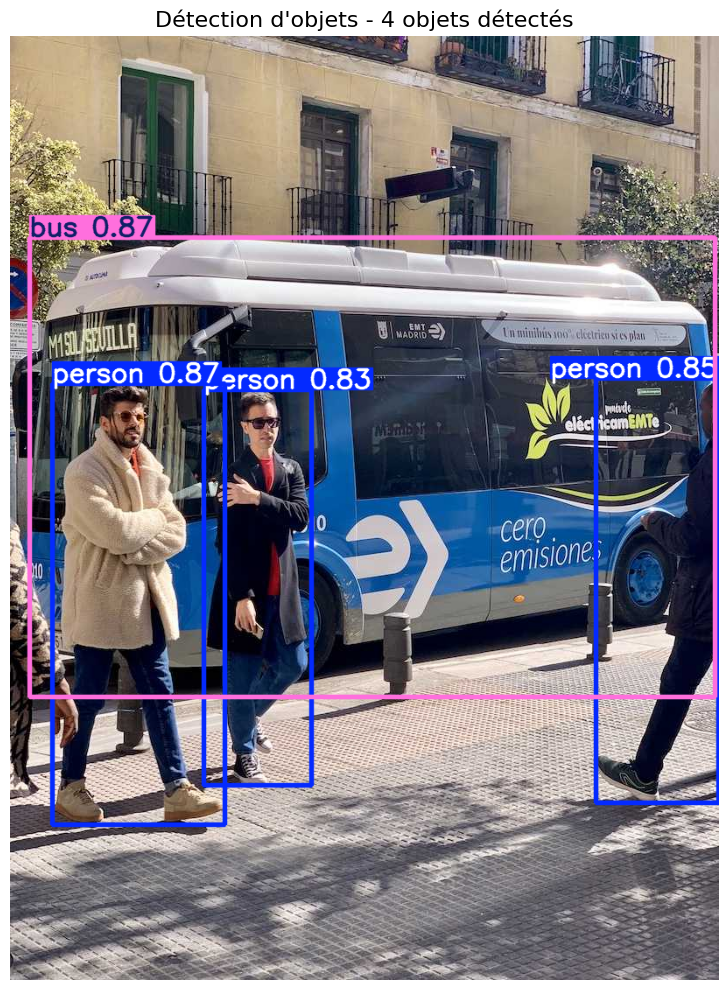

1.  Bus devant vous, TRÈS PROCHE - ATTENTION
2.  Personne détectée à gauche, Distance moyenne
3.  Personne détectée à droite, Distance moyenne
4.  Personne détectée devant vous, Distance moyenne
Analyse de la scène : 4 obstacle(s) détecté(s). Bus devant vous, très proche - attention. Personne détectée à gauche, distance moyenne. Personne détectée à droite, distance moyenne. Au total, 4 objets dans la scène : 3 person, 1 bus.
1. bus (confiance: 0.87) - devant vous, TRÈS PROCHE - ATTENTION
2. person (confiance: 0.87) - à gauche, Distance moyenne
3. person (confiance: 0.85) - à droite, Distance moyenne
4. person (confiance: 0.83) - devant vous, Distance moyenne


In [10]:
#TEST SUR IMAGE D'EXEMPLE
!wget -q https://ultralytics.com/images/bus.jpg -O test_image.jpg

print("Test sur une image d'exemple:")
afficher_resultats('test_image.jpg', conf_threshold=0.5)

#TEST SUR NNOS PROPRES IMAGES

#afficher_resultats('nom.jpg')

#possible de traiater plusieurs images


## Détéction sur vidéo

NB : On peut utiliser des vidéos faites par nous mêmes ou bien prendre des POV walking in the street sur youtube. Il faudrait qu'on essaye de tester plusieurs scènes, typiquement supermarché, pharamcie, parc, etc.

In [11]:
!wget https://www.pexels.com/download/video/3571264/ -O street_walking.mp4

--2025-12-02 11:01:42--  https://www.pexels.com/download/video/3571264/
Resolving www.pexels.com (www.pexels.com)... 104.18.67.220, 104.18.66.220, 2606:4700::6812:42dc, ...
Connecting to www.pexels.com (www.pexels.com)|104.18.67.220|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://videos.pexels.com/video-files/3571264/3571264-uhd_3840_2160_30fps.mp4 [following]
--2025-12-02 11:01:42--  https://videos.pexels.com/video-files/3571264/3571264-uhd_3840_2160_30fps.mp4
Resolving videos.pexels.com (videos.pexels.com)... 104.18.67.220, 104.18.66.220, 2606:4700::6812:42dc, ...
Connecting to videos.pexels.com (videos.pexels.com)|104.18.67.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56038183 (53M) [video/mp4]
Saving to: ‘street_walking.mp4’

street_walking.mp4  100%[===================>]  53.44M   212MB/s    in 0.3s    

2025-12-02 11:01:43 (212 MB/s) - ‘street_walking.mp4’ saved [56038183/56038183]



In [12]:
def detecter_video(video_path, output_path='output_video.mp4', conf_threshold=0.5):
    """
    Détection sur vidéo avec alertes
    """
    cap = cv2.VideoCapture(video_path)

    # Propriétés de la vidéo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Writer pour sauvegarder
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Détection toutes les 5 frames pour la vitesse
        if frame_count % 5 == 0:
            results = model(frame, conf=conf_threshold, verbose=False)
            annotated_frame = results[0].plot()

        out.write(annotated_frame)
        frame_count += 1

        if frame_count % 30 == 0:
            print(f"Traité {frame_count} frames...")

    cap.release()
    out.release()
    print(f"\nVidéo sauvegardée: {output_path}")

detecter_video('street_walking.mp4')

Traité 30 frames...
Traité 60 frames...
Traité 90 frames...
Traité 120 frames...
Traité 150 frames...
Traité 180 frames...
Traité 210 frames...
Traité 240 frames...
Traité 270 frames...
Traité 300 frames...
Traité 330 frames...
Traité 360 frames...
Traité 390 frames...
Traité 420 frames...
Traité 450 frames...
Traité 480 frames...
Traité 510 frames...
Traité 540 frames...
Traité 570 frames...
Traité 600 frames...
Traité 630 frames...
Traité 660 frames...
Traité 690 frames...
Traité 720 frames...
Traité 750 frames...
Traité 780 frames...
Traité 810 frames...
Traité 840 frames...
Traité 870 frames...
Traité 900 frames...
Traité 930 frames...
Traité 960 frames...
Traité 990 frames...

Vidéo sauvegardée: output_video.mp4


## Métriques et statistiques

In [13]:
def analyser_performances(image_paths, conf_threshold=0.5):
    """
    Analyse les performances sur un ensemble d'images
    """
    resultats = {
        'total_images': 0,
        'total_detections': 0,
        'objets_par_categorie': Counter(),
        'obstacles_critiques': 0
    }

    for img_path in image_paths:
        _, detections, alertes = detecter_et_analyser(img_path, conf_threshold)
        if detections:
            resultats['total_images'] += 1
            resultats['total_detections'] += len(detections)
            resultats['obstacles_critiques'] += len(alertes)

            for det in detections:
                resultats['objets_par_categorie'][det['classe']] += 1


    print(f"Images analysées: {resultats['total_images']}")
    print(f"Détections totales: {resultats['total_detections']}")
    print(f"Moyenne par image: {resultats['total_detections']/max(resultats['total_images'],1):.1f}")
    print(f"Obstacles critiques: {resultats['obstacles_critiques']}")

    print("\nTop 10 objets détectés:")
    for obj, count in resultats['objets_par_categorie'].most_common(10):
        print(f"  {obj}: {count}")

# Module 2 : OCR

##